In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
ϕ_list = np.load("v_list_1.npy")
ems_list = np.load("e_list_1.npy")

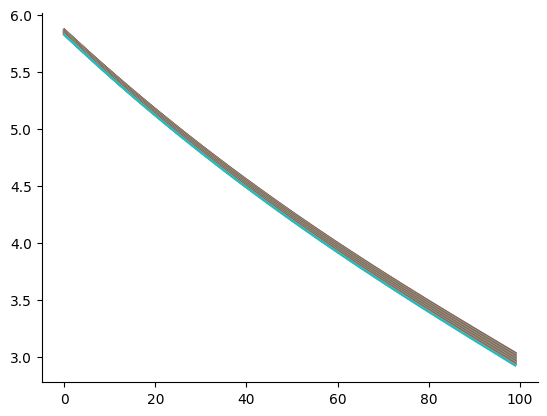

In [6]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

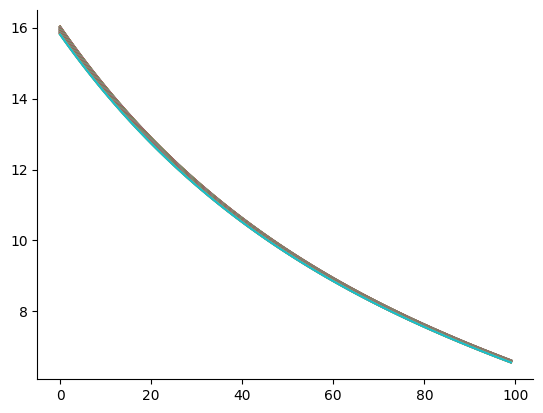

In [7]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [8]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.95
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.099115628257	 rhs error: 0.106448320726
Episode: 2	 lhs error: 0.106986230949	 rhs error: 0.114268370210
Episode: 3	 lhs error: 0.109690179063	 rhs error: 0.116179503997
Episode: 4	 lhs error: 0.107829441242	 rhs error: 0.115453119225
Episode: 5	 lhs error: 0.105518513328	 rhs error: 0.113536106941
Episode: 6	 lhs error: 0.103632692493	 rhs error: 0.110925900157
Episode: 7	 lhs error: 0.101108650387	 rhs error: 0.107883186713
Episode: 8	 lhs error: 0.098128367099	 rhs error: 0.104648289079
Episode: 9	 lhs error: 0.095498035952	 rhs error: 0.101371455803
Episode: 10	 lhs error: 0.092480073206	 rhs error: 0.098123975697
Episode: 11	 lhs error: 0.089798535184	 rhs error: 0.094981484666
Episode: 12	 lhs error: 0.087314929147	 rhs error: 0.091968909663
Episode: 13	 lhs error: 0.085245572026	 rhs error: 0.089107728408
Episode: 14	 lhs error: 0.082538697332	 rhs error: 0.086410481618
Episode: 15	 lhs error: 0.080736776816	 rhs error: 0.083894088577
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.050636040335	 rhs error: 0.050619164842
Episode: 126	 lhs error: 0.050408858671	 rhs error: 0.050499535077
Episode: 127	 lhs error: 0.050404813533	 rhs error: 0.050376713469
Episode: 128	 lhs error: 0.050352741055	 rhs error: 0.050246876907
Episode: 129	 lhs error: 0.050159056778	 rhs error: 0.050113223957
Episode: 130	 lhs error: 0.050003439039	 rhs error: 0.049980433576
Episode: 131	 lhs error: 0.049874186203	 rhs error: 0.049846366247
Episode: 132	 lhs error: 0.049745360303	 rhs error: 0.049709774478
Episode: 133	 lhs error: 0.049606806827	 rhs error: 0.049570642273
Episode: 134	 lhs error: 0.049460749685	 rhs error: 0.049429323629
Episode: 135	 lhs error: 0.049312434291	 rhs error: 0.049285994184
Episode: 136	 lhs error: 0.049163449642	 rhs error: 0.049140578573
Episode: 137	 lhs error: 0.049012642220	 rhs error: 0.048992949774
Episode: 138	 lhs error: 0.048859227799	 rhs error: 0.048843052283
Episode: 139	 lhs error: 0.048703260036	 rhs error: 0.04869087

Episode: 249	 lhs error: 0.028261758676	 rhs error: 0.028469386415
Episode: 250	 lhs error: 0.028132302836	 rhs error: 0.028419639054
Episode: 251	 lhs error: 0.028623931962	 rhs error: 0.028363552381
Episode: 252	 lhs error: 0.028348736427	 rhs error: 0.028331199082
Episode: 253	 lhs error: 0.028048831384	 rhs error: 0.028272867073
Episode: 254	 lhs error: 0.027816398578	 rhs error: 0.028205299221
Episode: 255	 lhs error: 0.027708308862	 rhs error: 0.028132112488
Episode: 256	 lhs error: 0.028299570452	 rhs error: 0.028056614534
Episode: 257	 lhs error: 0.027989348373	 rhs error: 0.028008842704
Episode: 258	 lhs error: 0.027602815103	 rhs error: 0.027935660483
Episode: 259	 lhs error: 0.028082200841	 rhs error: 0.027851332248
Episode: 260	 lhs error: 0.027762311592	 rhs error: 0.027784836091
Episode: 261	 lhs error: 0.027482737378	 rhs error: 0.027701567485
Episode: 262	 lhs error: 0.027347302462	 rhs error: 0.027612446213
Episode: 263	 lhs error: 0.027281006679	 rhs error: 0.02752162

Episode: 373	 lhs error: 0.020042557081	 rhs error: 0.024538195855
Episode: 374	 lhs error: 0.020006611678	 rhs error: 0.024565843919
Episode: 375	 lhs error: 0.019969023645	 rhs error: 0.024591397378
Episode: 376	 lhs error: 0.019929825423	 rhs error: 0.024614901737
Episode: 377	 lhs error: 0.019889101166	 rhs error: 0.024636401818
Episode: 378	 lhs error: 0.019846910505	 rhs error: 0.024655940820
Episode: 379	 lhs error: 0.019803291721	 rhs error: 0.024673560859
Episode: 380	 lhs error: 0.019758319686	 rhs error: 0.024689303335
Episode: 381	 lhs error: 0.019712084874	 rhs error: 0.024703208214
Episode: 382	 lhs error: 0.019664704975	 rhs error: 0.024715313729
Episode: 383	 lhs error: 0.019616493432	 rhs error: 0.024725655658
Episode: 384	 lhs error: 0.019568124936	 rhs error: 0.024734263262
Episode: 385	 lhs error: 0.019522446788	 rhs error: 0.024741149531
Episode: 386	 lhs error: 0.018823137793	 rhs error: 0.024747353275
Episode: 387	 lhs error: 0.019417804724	 rhs error: 0.02476206

Episode: 497	 lhs error: 0.014475592048	 rhs error: 0.023654100386
Episode: 498	 lhs error: 0.014440377766	 rhs error: 0.023618594400
Episode: 499	 lhs error: 0.014375737396	 rhs error: 0.023581913513
Episode: 500	 lhs error: 0.014345558828	 rhs error: 0.023546584335
Episode: 501	 lhs error: 0.014323878776	 rhs error: 0.023508222559
Episode: 502	 lhs error: 0.014303185883	 rhs error: 0.023489510576
Episode: 503	 lhs error: 0.014286567621	 rhs error: 0.023479819268
Episode: 504	 lhs error: 0.014265128076	 rhs error: 0.023469771543
Episode: 505	 lhs error: 0.014240359020	 rhs error: 0.023459274416
Episode: 506	 lhs error: 0.014216939936	 rhs error: 0.023448168559
Episode: 507	 lhs error: 0.014194334673	 rhs error: 0.023436438483
Episode: 508	 lhs error: 0.014171336293	 rhs error: 0.023424067321
Episode: 509	 lhs error: 0.014148226020	 rhs error: 0.023411053819
Episode: 510	 lhs error: 0.014124030403	 rhs error: 0.023397452528
Episode: 511	 lhs error: 0.014099524497	 rhs error: 0.02338326

Episode: 620	 lhs error: 0.011139494202	 rhs error: 0.019908912824
Episode: 621	 lhs error: 0.011111597589	 rhs error: 0.019877135533
Episode: 622	 lhs error: 0.011082992378	 rhs error: 0.019845204801
Episode: 623	 lhs error: 0.011054103723	 rhs error: 0.019813154903
Episode: 624	 lhs error: 0.011025221012	 rhs error: 0.019780950522
Episode: 625	 lhs error: 0.010996239700	 rhs error: 0.019748637830
Episode: 626	 lhs error: 0.010965663577	 rhs error: 0.019716167505
Episode: 627	 lhs error: 0.010936493731	 rhs error: 0.019683580417
Episode: 628	 lhs error: 0.010906091455	 rhs error: 0.019650885012
Episode: 629	 lhs error: 0.010875367036	 rhs error: 0.019618056039
Episode: 630	 lhs error: 0.010846756531	 rhs error: 0.019585080923
Episode: 631	 lhs error: 0.010834675089	 rhs error: 0.019552036646
Episode: 632	 lhs error: 0.010823143679	 rhs error: 0.019518821593
Episode: 633	 lhs error: 0.010810414987	 rhs error: 0.019485545968
Episode: 634	 lhs error: 0.010797220234	 rhs error: 0.01945212

Episode: 743	 lhs error: 0.008808320573	 rhs error: 0.018223296280
Episode: 744	 lhs error: 0.008788681563	 rhs error: 0.018233238220
Episode: 745	 lhs error: 0.008768311102	 rhs error: 0.018242953656
Episode: 746	 lhs error: 0.008748582057	 rhs error: 0.018252502806
Episode: 747	 lhs error: 0.008727571379	 rhs error: 0.018261779885
Episode: 748	 lhs error: 0.008706506088	 rhs error: 0.018270897553
Episode: 749	 lhs error: 0.008686322904	 rhs error: 0.018279838631
Episode: 750	 lhs error: 0.008664078370	 rhs error: 0.018288510840
Episode: 751	 lhs error: 0.008647304237	 rhs error: 0.018297063930
Episode: 752	 lhs error: 0.008638321944	 rhs error: 0.018305384707
Episode: 753	 lhs error: 0.008628186927	 rhs error: 0.018313485395
Episode: 754	 lhs error: 0.008618720494	 rhs error: 0.018321440343
Episode: 755	 lhs error: 0.008607754214	 rhs error: 0.018329165827
Episode: 756	 lhs error: 0.008598220782	 rhs error: 0.018336775476
Episode: 757	 lhs error: 0.008586365600	 rhs error: 0.01834408

Episode: 867	 lhs error: 0.007106090656	 rhs error: 0.018368212832
Episode: 868	 lhs error: 0.007098290059	 rhs error: 0.018364068126
Episode: 869	 lhs error: 0.007088282683	 rhs error: 0.018359766310
Episode: 870	 lhs error: 0.007079789023	 rhs error: 0.018355584981
Episode: 871	 lhs error: 0.007069868280	 rhs error: 0.018351266320
Episode: 872	 lhs error: 0.007061338366	 rhs error: 0.018347001534
Episode: 873	 lhs error: 0.007050346163	 rhs error: 0.018342535100
Episode: 874	 lhs error: 0.007040990045	 rhs error: 0.018338209972
Episode: 875	 lhs error: 0.007030032964	 rhs error: 0.018333738805
Episode: 876	 lhs error: 0.007020618731	 rhs error: 0.018329341953
Episode: 877	 lhs error: 0.007008485806	 rhs error: 0.018324732572
Episode: 878	 lhs error: 0.006998178644	 rhs error: 0.018320325527
Episode: 879	 lhs error: 0.006987291246	 rhs error: 0.018315754531
Episode: 880	 lhs error: 0.006975357694	 rhs error: 0.018311150079
Episode: 881	 lhs error: 0.006964735035	 rhs error: 0.01830659

Episode: 991	 lhs error: 0.005838995528	 rhs error: 0.017761280920
Episode: 992	 lhs error: 0.005828785544	 rhs error: 0.017756889778
Episode: 993	 lhs error: 0.005817909488	 rhs error: 0.017752442635
Episode: 994	 lhs error: 0.005807150749	 rhs error: 0.017748019692
Episode: 995	 lhs error: 0.005796290821	 rhs error: 0.017743619721
Episode: 996	 lhs error: 0.005784853611	 rhs error: 0.017739217003
Episode: 997	 lhs error: 0.005773893665	 rhs error: 0.017734892575
Episode: 998	 lhs error: 0.005762439878	 rhs error: 0.017730533688
Episode: 999	 lhs error: 0.005752079521	 rhs error: 0.017726219243
Episode: 1000	 lhs error: 0.005745795812	 rhs error: 0.017721891373
Episode: 1001	 lhs error: 0.005739874060	 rhs error: 0.017717644059
Episode: 1002	 lhs error: 0.005733100975	 rhs error: 0.017713353880
Episode: 1003	 lhs error: 0.005727079310	 rhs error: 0.017709153892
Episode: 1004	 lhs error: 0.005719369398	 rhs error: 0.017704839419
Episode: 1005	 lhs error: 0.005713245851	 rhs error: 0.01

Episode: 1115	 lhs error: 0.004851936384	 rhs error: 0.017368227108
Episode: 1116	 lhs error: 0.004843840724	 rhs error: 0.017366324628
Episode: 1117	 lhs error: 0.004835700662	 rhs error: 0.017364475003
Episode: 1118	 lhs error: 0.004827314260	 rhs error: 0.017362574666
Episode: 1119	 lhs error: 0.004819027639	 rhs error: 0.017360779770
Episode: 1120	 lhs error: 0.004810447462	 rhs error: 0.017358891504
Episode: 1121	 lhs error: 0.004801907136	 rhs error: 0.017357068493
Episode: 1122	 lhs error: 0.004793061236	 rhs error: 0.017355230748
Episode: 1123	 lhs error: 0.004785981488	 rhs error: 0.017353501602
Episode: 1124	 lhs error: 0.004780970963	 rhs error: 0.017351723212
Episode: 1125	 lhs error: 0.004775725832	 rhs error: 0.017349921282
Episode: 1126	 lhs error: 0.004770502900	 rhs error: 0.017348296953
Episode: 1127	 lhs error: 0.004765042613	 rhs error: 0.017346510444
Episode: 1128	 lhs error: 0.004759411425	 rhs error: 0.017344788809
Episode: 1129	 lhs error: 0.004753802223	 rhs er

Episode: 1239	 lhs error: 0.004068560108	 rhs error: 0.017238205408
Episode: 1240	 lhs error: 0.004064223584	 rhs error: 0.017237701579
Episode: 1241	 lhs error: 0.004059416234	 rhs error: 0.017237348679
Episode: 1242	 lhs error: 0.004054491436	 rhs error: 0.017236941418
Episode: 1243	 lhs error: 0.004049786647	 rhs error: 0.017236477703
Episode: 1244	 lhs error: 0.004044809212	 rhs error: 0.017236101767
Episode: 1245	 lhs error: 0.004039623283	 rhs error: 0.017235782986
Episode: 1246	 lhs error: 0.004034313220	 rhs error: 0.017235392883
Episode: 1247	 lhs error: 0.004029215300	 rhs error: 0.017234945435
Episode: 1248	 lhs error: 0.004023806166	 rhs error: 0.017234628116
Episode: 1249	 lhs error: 0.004018233001	 rhs error: 0.017234291003
Episode: 1250	 lhs error: 0.004012683352	 rhs error: 0.017233932826
Episode: 1251	 lhs error: 0.004006961881	 rhs error: 0.017233580506
Episode: 1252	 lhs error: 0.004001243033	 rhs error: 0.017233235723
Episode: 1253	 lhs error: 0.003995292737	 rhs er

Episode: 1363	 lhs error: 0.003440668249	 rhs error: 0.017218068118
Episode: 1364	 lhs error: 0.003435213696	 rhs error: 0.017218120586
Episode: 1365	 lhs error: 0.003430701092	 rhs error: 0.017218168699
Episode: 1366	 lhs error: 0.003428000824	 rhs error: 0.017217992097
Episode: 1367	 lhs error: 0.003424147495	 rhs error: 0.017218034076
Episode: 1368	 lhs error: 0.003419974223	 rhs error: 0.017218030034
Episode: 1369	 lhs error: 0.003416811118	 rhs error: 0.017217962433
Episode: 1370	 lhs error: 0.003412061699	 rhs error: 0.017218047651
Episode: 1371	 lhs error: 0.003408491509	 rhs error: 0.017217959035
Episode: 1372	 lhs error: 0.003403994727	 rhs error: 0.017217959630
Episode: 1373	 lhs error: 0.003400639143	 rhs error: 0.017217895374
Episode: 1374	 lhs error: 0.003395195988	 rhs error: 0.017218020888
Episode: 1375	 lhs error: 0.003391452663	 rhs error: 0.017217874286
Episode: 1376	 lhs error: 0.003387123375	 rhs error: 0.017217890661
Episode: 1377	 lhs error: 0.003382374236	 rhs er

Episode: 1487	 lhs error: 0.002931937488	 rhs error: 0.017219120523
Episode: 1488	 lhs error: 0.002927888776	 rhs error: 0.017219180096
Episode: 1489	 lhs error: 0.002926049981	 rhs error: 0.017219113302
Episode: 1490	 lhs error: 0.002920602967	 rhs error: 0.017219344197
Episode: 1491	 lhs error: 0.002917899720	 rhs error: 0.017219276063
Episode: 1492	 lhs error: 0.002913529039	 rhs error: 0.017219375432
Episode: 1493	 lhs error: 0.002910972557	 rhs error: 0.017219368203
Episode: 1494	 lhs error: 0.002905138646	 rhs error: 0.017219548628
Episode: 1495	 lhs error: 0.002902662493	 rhs error: 0.017219456105
Episode: 1496	 lhs error: 0.002899644941	 rhs error: 0.017219540507
Episode: 1497	 lhs error: 0.002892947244	 rhs error: 0.017219796925
Episode: 1498	 lhs error: 0.002891046473	 rhs error: 0.017219642317
Episode: 1499	 lhs error: 0.002886075608	 rhs error: 0.017219824548
Episode: 1500	 lhs error: 0.002881579168	 rhs error: 0.017219889099
Episode: 1501	 lhs error: 0.002877855249	 rhs er

Episode: 1611	 lhs error: 0.002509091228	 rhs error: 0.017232341276
Episode: 1612	 lhs error: 0.002506726013	 rhs error: 0.017232232323
Episode: 1613	 lhs error: 0.002504045441	 rhs error: 0.017232155644
Episode: 1614	 lhs error: 0.002500741006	 rhs error: 0.017232100333
Episode: 1615	 lhs error: 0.002497235707	 rhs error: 0.017231986653
Episode: 1616	 lhs error: 0.002495003498	 rhs error: 0.017231795930
Episode: 1617	 lhs error: 0.002491845772	 rhs error: 0.017231707528
Episode: 1618	 lhs error: 0.002488427191	 rhs error: 0.017231595526
Episode: 1619	 lhs error: 0.002485174189	 rhs error: 0.017231442933
Episode: 1620	 lhs error: 0.002482894737	 rhs error: 0.017231286658
Episode: 1621	 lhs error: 0.002478484136	 rhs error: 0.017231242733
Episode: 1622	 lhs error: 0.002474984122	 rhs error: 0.017231039221
Episode: 1623	 lhs error: 0.002473359660	 rhs error: 0.017230823659
Episode: 1624	 lhs error: 0.002468255986	 rhs error: 0.017230824461
Episode: 1625	 lhs error: 0.002465170260	 rhs er

Episode: 1734	 lhs error: 0.002166835194	 rhs error: 0.017218205961
Episode: 1735	 lhs error: 0.002163256711	 rhs error: 0.017218265050
Episode: 1736	 lhs error: 0.002160932023	 rhs error: 0.017218225365
Episode: 1737	 lhs error: 0.002159066042	 rhs error: 0.017218192713
Episode: 1738	 lhs error: 0.002156139667	 rhs error: 0.017218228979
Episode: 1739	 lhs error: 0.002154157423	 rhs error: 0.017218130268
Episode: 1740	 lhs error: 0.002152498407	 rhs error: 0.017218086571
Episode: 1741	 lhs error: 0.002056118081	 rhs error: 0.017218819342
Episode: 1742	 lhs error: 0.002175884378	 rhs error: 0.017208540504
Episode: 1743	 lhs error: 0.002146500315	 rhs error: 0.017213098962
Episode: 1744	 lhs error: 0.002139685409	 rhs error: 0.017214030518
Episode: 1745	 lhs error: 0.002135894391	 rhs error: 0.017214335006
Episode: 1746	 lhs error: 0.002133288122	 rhs error: 0.017214398275
Episode: 1747	 lhs error: 0.002131518112	 rhs error: 0.017214394888
Episode: 1748	 lhs error: 0.002129163344	 rhs er

Episode: 1858	 lhs error: 0.001670684647	 rhs error: 0.017197103473
Episode: 1859	 lhs error: 0.001666092772	 rhs error: 0.017197007642
Episode: 1860	 lhs error: 0.001659309383	 rhs error: 0.017196991525
Episode: 1861	 lhs error: 0.001656999142	 rhs error: 0.017196734621
Episode: 1862	 lhs error: 0.001649661891	 rhs error: 0.017196783493
Episode: 1863	 lhs error: 0.001647656591	 rhs error: 0.017196550633
Episode: 1864	 lhs error: 0.001638973162	 rhs error: 0.017196682634
Episode: 1865	 lhs error: 0.001638224172	 rhs error: 0.017196336622
Episode: 1866	 lhs error: 0.001542140602	 rhs error: 0.017197143670
Episode: 1867	 lhs error: 0.001651888548	 rhs error: 0.017187742606
Episode: 1868	 lhs error: 0.001622289100	 rhs error: 0.017191585851
Episode: 1869	 lhs error: 0.001614087260	 rhs error: 0.017192408055
Episode: 1870	 lhs error: 0.001607946076	 rhs error: 0.017192697837
Episode: 1871	 lhs error: 0.001602667898	 rhs error: 0.017192765089
Episode: 1872	 lhs error: 0.001597936325	 rhs er

Episode: 1982	 lhs error: 0.001058437612	 rhs error: 0.017175501780
Episode: 1983	 lhs error: 0.001054047891	 rhs error: 0.017175679355
Episode: 1984	 lhs error: 0.001049431568	 rhs error: 0.017175800028
Episode: 1985	 lhs error: 0.001045444147	 rhs error: 0.017175866722
Episode: 1986	 lhs error: 0.001041241019	 rhs error: 0.017175969505
Episode: 1987	 lhs error: 0.001036620288	 rhs error: 0.017176055103
Episode: 1988	 lhs error: 0.001032625370	 rhs error: 0.017176114421
Episode: 1989	 lhs error: 0.001027585099	 rhs error: 0.017176215987
Episode: 1990	 lhs error: 0.001023805567	 rhs error: 0.017176197456
Episode: 1991	 lhs error: 0.001018492808	 rhs error: 0.017176280687
Episode: 1992	 lhs error: 0.001014840947	 rhs error: 0.017176226659
Episode: 1993	 lhs error: 0.001011354685	 rhs error: 0.017176264199
Episode: 1994	 lhs error: 0.001005666555	 rhs error: 0.017176386469
Episode: 1995	 lhs error: 0.001002490596	 rhs error: 0.017176349811
Episode: 1996	 lhs error: 0.000997244562	 rhs er

In [9]:
np.save(f"ems_{λ}_{y_lower}", ems)
np.save(f"v_{λ}_{y_lower}", v0)

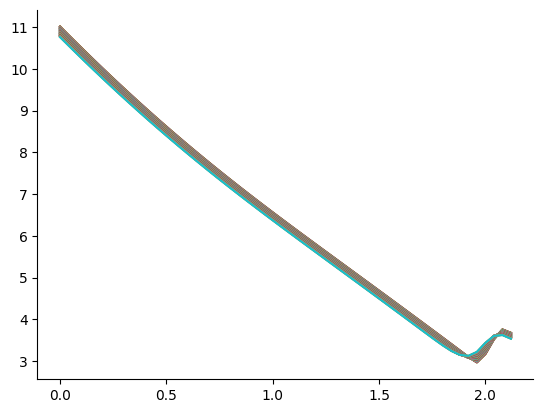

In [10]:
plt.plot(y1_grid_cap, ems)
plt.show()

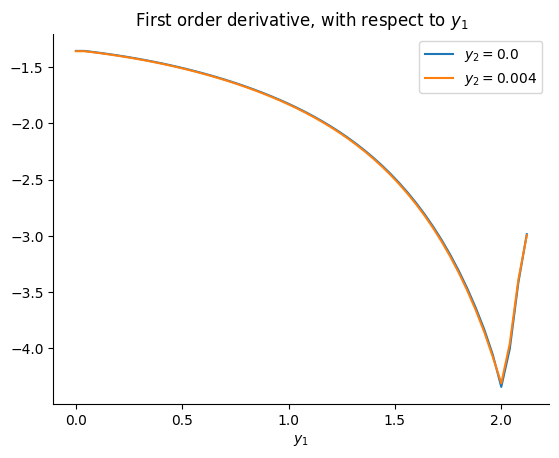

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

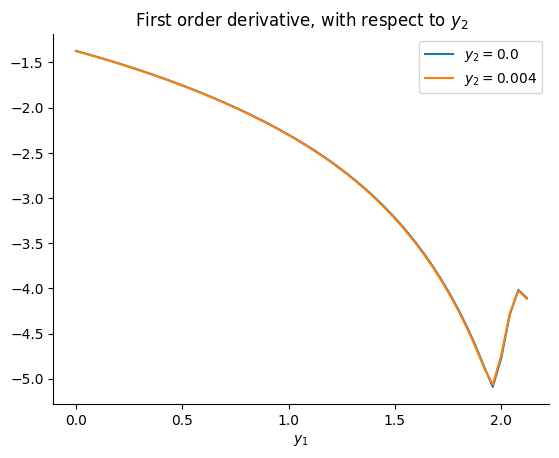

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

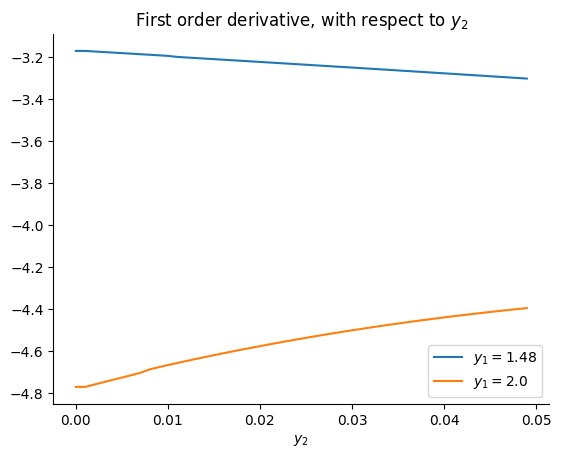

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

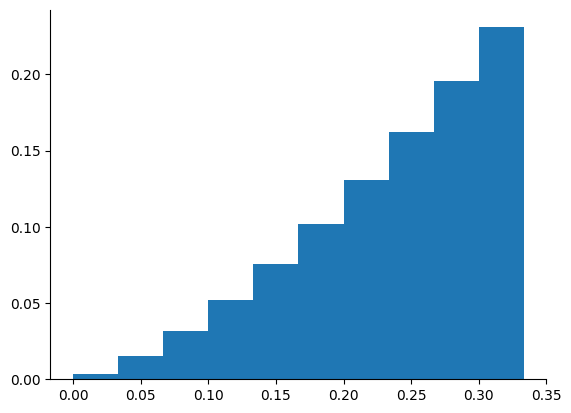

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

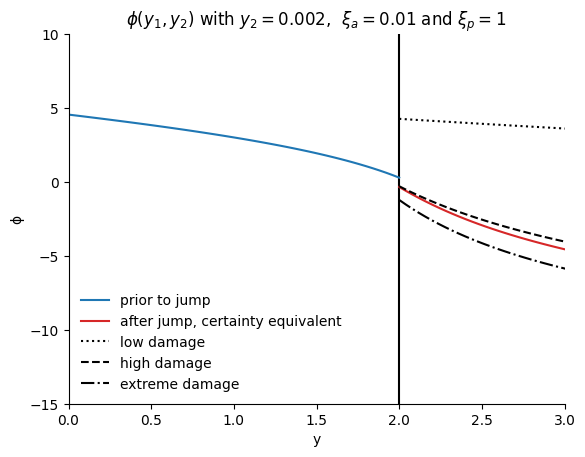

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

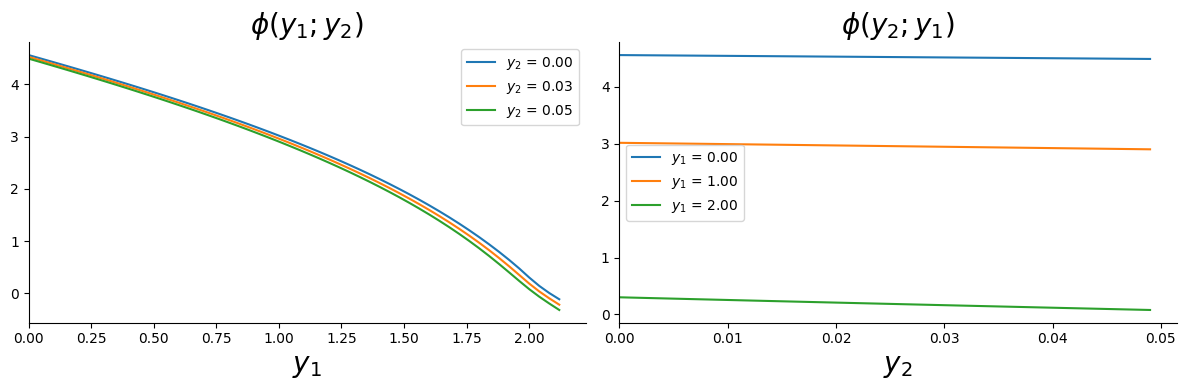

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

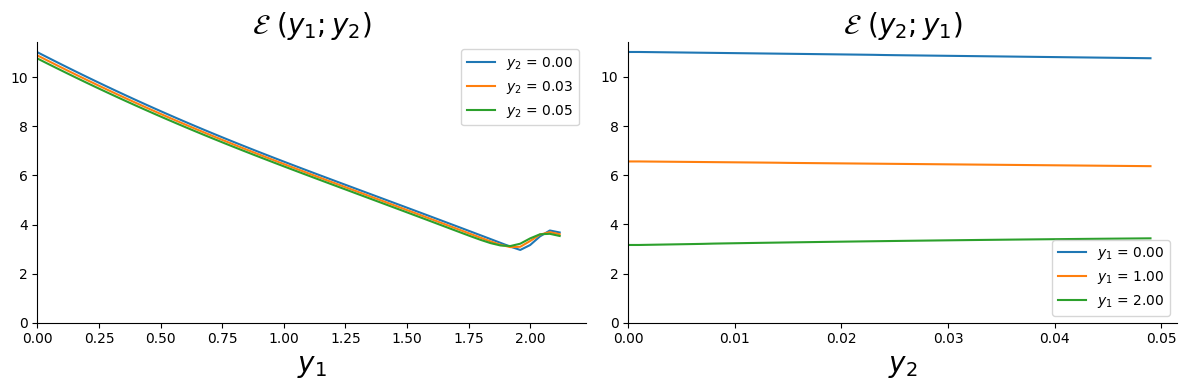

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

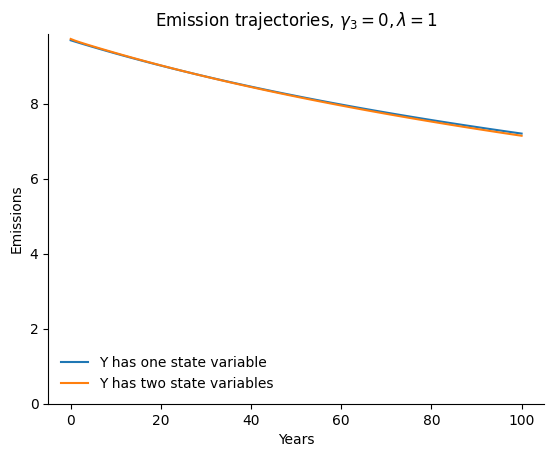

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [24]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [25]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

# pickle.dump(simul, open("simul_2", "wb"))

In [26]:
y1t_prejump

array([1.1       , 1.10795624, 1.11809119, 1.12897254, 1.14007678,
       1.15121278, 1.16231099, 1.17334635, 1.18431026, 1.19519987,
       1.20601449, 1.21675424, 1.22741952, 1.23801082, 1.24852863,
       1.25897349, 1.26934592, 1.27964644, 1.28987555, 1.30003386,
       1.31012193, 1.32014024, 1.33008929, 1.33996956, 1.34978152,
       1.35952564, 1.36920239, 1.37881214, 1.38835531, 1.39783237,
       1.40724377, 1.41659001, 1.42587157, 1.4350889 , 1.44424245,
       1.45333267, 1.46235997, 1.4713248 , 1.48022756, 1.48906867,
       1.49784841, 1.50656713, 1.51522526, 1.5238232 , 1.53236139,
       1.54084023, 1.54926015, 1.55762155, 1.56592484, 1.57417043,
       1.58235869, 1.59049001, 1.5985648 , 1.60658343, 1.61454617,
       1.62245333, 1.63030526, 1.63810235, 1.64584498, 1.6535335 ,
       1.66116826, 1.66874962, 1.67627797, 1.68375368, 1.69117711,
       1.6985486 , 1.70586853, 1.71313723, 1.72035507, 1.7275224 ,
       1.73463941, 1.74170642, 1.74872377, 1.7556918 , 1.76261

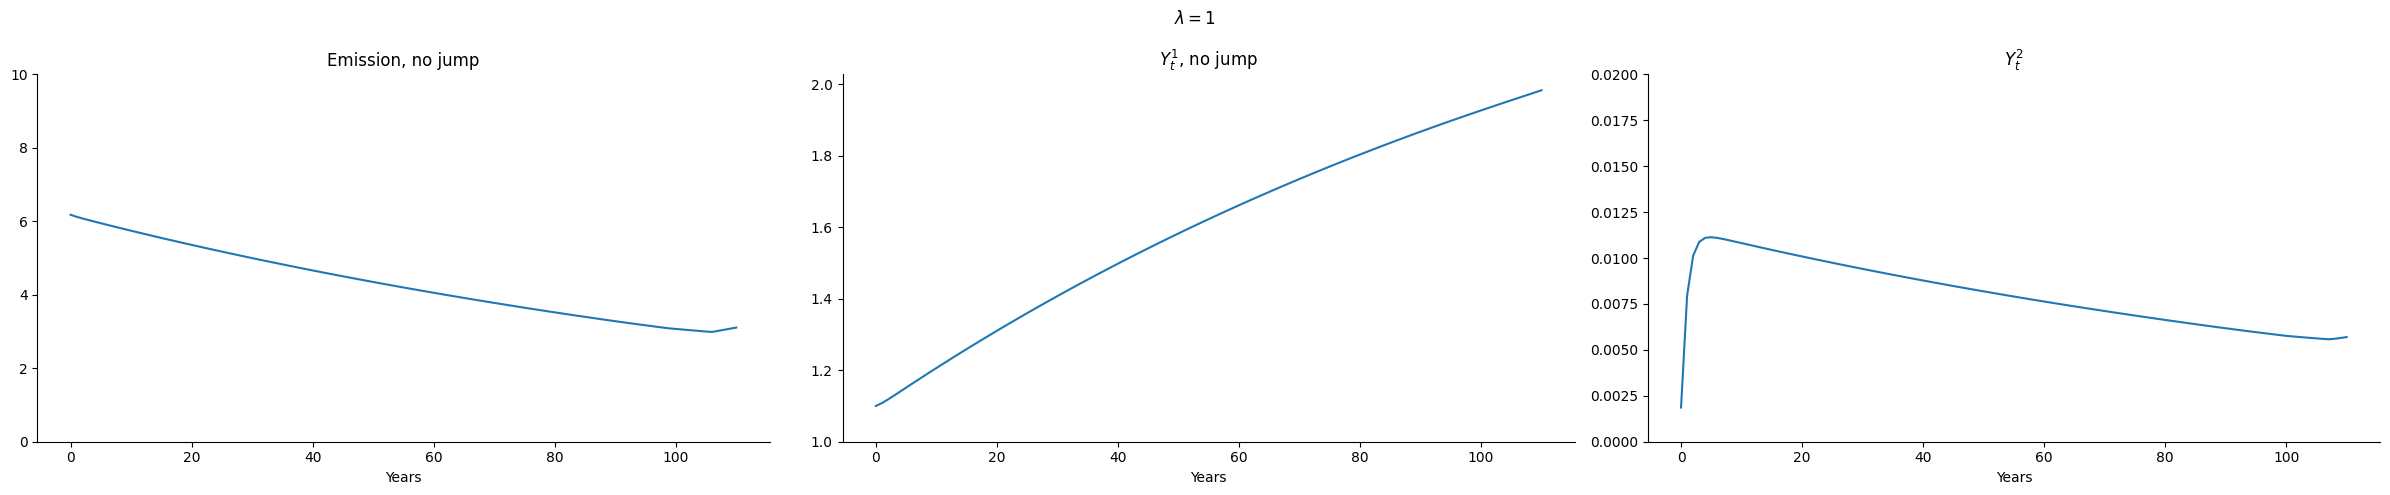

In [27]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

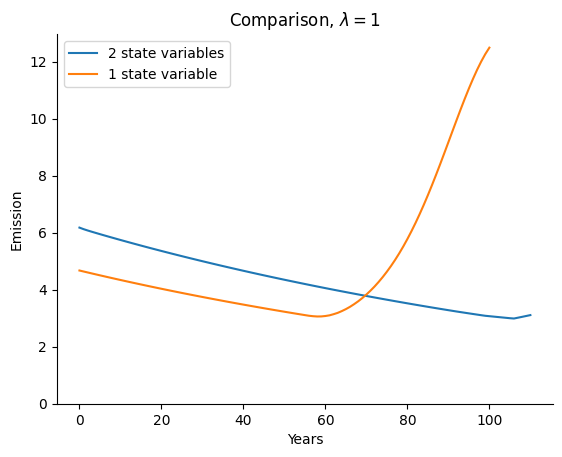

In [30]:
et_1state = np.load("et_1state_cal.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [31]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [32]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [33]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

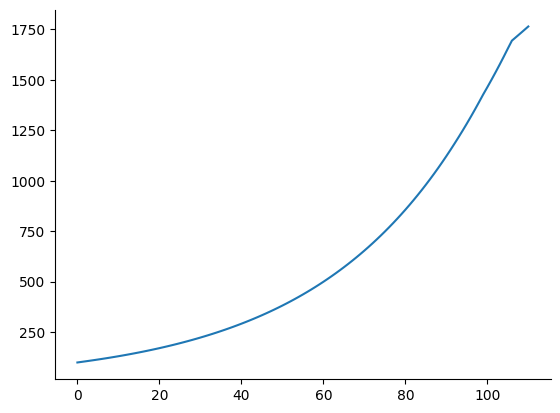

In [34]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)